# Webscraping Analysis on GitHub Repositories

We will be scraping GitHub repositories and organize the information in a Pandas dataframe. After that, we will use linear regressions to gain meaningful insights on the data we collected.
    
 

In [3]:
# imports and setup 
from bs4 import BeautifulSoup
# you can use either of these libraries to get html from a website
import time
import os

import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 
# where the data is stored
DATA_PATH = "data"


### Scrape GitHub Repository List using BeautifulSoup

We will be scraping data from [this repository list](https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories).

Before we can start to scrape any website we should go through the terms of service and policy documents of the website. Almost all websites post conditions to use their data. Here is the terms of [https://github.com/](https://github.com/). In our case, we are allowed to scrape the repository, but all use of GitHub data gathered through scraping must comply with the GitHub Privacy Statement.

We avoided any problems with GitHub blocking us from downloading the data by saving all the html files in the data folder. The path to data folder is stored in `DATA_PATH` variable. Additionally, the data folder contains highly starred repositories saved as `searchPage1.html`,`searchPage2.html`,`searchPage3.html` ... `searchPage10.html`

We will create a single soup using BeautifulSoups' [append()](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#append) function.

In [4]:
soup = BeautifulSoup(open(DATA_PATH + "/searchPage1.html"), "html.parser")
for i in range(2, 10):
    html = (DATA_PATH + "/searchPage" + str(i) + ".html")
    soup.append(BeautifulSoup(open(html, encoding = "utf8"), "html.parser"))

### Extract Data

We will now extract the certain data for each repository and create a Pandas Dataframe with a row for each repository and a column for each of these datums.

+ The name of the repository
+ The primary language (there are multiple or none, if multiple, use the first one, if none, use "none")
+ The number of watches
+ The number of stars
+ Number of forks
+ Number of commits
+ Number of branches
+ Number of contributors
+ Number of issues
+ Length of readme file.


In [6]:
import urllib.request

repo_list = soup.find_all(class_="repo-list-item hx_hit-repo d-flex flex-justify-start py-4 public source")

links = []
for repo in repo_list:
    repo_name = repo.find('a').text.split("/")
    name = repo_name[0].strip()
    link = name

    links.append(link)
links

links1 = []
for repo1 in repo_list:
    repo_name1 = repo1.find('a').text.split("/")
    name1 = repo_name1[1].strip()
    link1 = name1

    links1.append(link1)
    
data = []
for i in range(len(repo_list)):
    soup1 = BeautifulSoup(open(DATA_PATH + "/" + links[i] + "/" + links1[i] + ".html", encoding = "utf8"), "html.parser")
    # name
    name = soup1.find(class_='mr-2 flex-self-stretch').text.strip()
    # language
    if soup1.find(class_="d-flex repository-lang-stats-graph") == None:
        language = "None"
    else:
        language = soup1.find(class_="d-flex repository-lang-stats-graph").text.split()[0]
        if language == "Jupyter":
            language1 = soup1.find(class_="d-flex repository-lang-stats-graph").text.split()[0]
            language2 = soup1.find(class_="d-flex repository-lang-stats-graph").text.split()[1]
            language = language1 + ' ' + language2
        else:
            language = soup1.find(class_="d-flex repository-lang-stats-graph").text.split()[0]



    watches, stars, forks = soup1.find_all(class_="social-count")
    # stars
    stars = stars["aria-label"].split()[0]
    stars = int(stars)

    # watches
    watches = watches["aria-label"].split()[0]
    watches = int(watches)

    # forks
    forks = forks["aria-label"].split()[0]
    forks = int(forks)

    # commits
    commits = soup1.find(class_="commits").text.split()[0]
    commits = int(commits.replace(',', ""))

    num_sum = soup1.find_all(class_="text-emphasized")
    # branches
    branches = num_sum[1].text.split()[0]
    branches = int(branches.replace(',', ""))

    # contributors
    contributors = num_sum[4].text.split()[0]
    contributors = contributors.replace('+', "")
    if contributors == '∞':
        contributors = 15600
    else:
        contributors = int(contributors.replace(',', ""))

    counter = soup1.find_all(class_="Counter")

    # issues
    issues = counter[0].text.strip()
    issues = issues.replace("+", "")
    issues = int(issues.replace(',', ""))
    issues

    # length of readme
    readme = len(soup1.select('div.Box-body')[0].get_text())

    data.append({"name":name, "language":language, "stars":stars, "watches":watches, "forks":forks, "commits":commits,
                 "branches":branches, "contributors": contributors, "issues": issues, "readme":readme})  

project_info = pd.DataFrame(data)  
project_info.to_csv('project_info.csv', index=False)
project_info

,name,language,stars,watches,forks,commits,branches,contributors,issues,readme
0,freeCodeCamp,JavaScript,308649,8376,23684,25355,5,3999,163,6179
1,996.ICU,Rust,249141,4523,21217,3019,1,605,25,4635
2,vue,JavaScript,156926,6012,23646,3085,44,289,291,2873
3,react,JavaScript,143727,6636,27597,12812,49,1361,483,3287
4,tensorflow,C++,140937,8485,79892,78840,33,2396,3102,3458
...,...,...,...,...,...,...,...,...,...,...
85,markdown-here,JavaScript,43759,1032,7727,807,10,12,246,10278
86,Front-end-Developer-Interview-Questions,HTML,43600,2409,8776,786,3,208,5,2660
87,resume.github.com,JavaScript,43586,336,1148,263,6,48,29,511
88,awesome-machine-learning,Python,43531,3319,11012,1368,2,416,0,99121


Note: There was one repository flagged as having infinite contributers (the Linux kernel). We will assume that it has 15600 contributors. This is an estimate based on a google search. Further, another repository has "5000+" issues, we will assume it will be just 5000.

## Analyzing the Repository Data

We will now analyze the data collected using regression tools. The goal is to identify properties that make a repository popular.

In [7]:
project_info = pd.read_csv('project_info.csv')
project_info.head()

,name,language,stars,watches,forks,commits,branches,contributors,issues,readme
0,freeCodeCamp,JavaScript,308649,8376,23684,25355,5,3999,163,6179
1,996.ICU,Rust,249141,4523,21217,3019,1,605,25,4635
2,vue,JavaScript,156926,6012,23646,3085,44,289,291,2873
3,react,JavaScript,143727,6636,27597,12812,49,1361,483,3287
4,tensorflow,C++,140937,8485,79892,78840,33,2396,3102,3458


### Describing the Data

We will get an overview of the data and compute the correlation matrix. Additionally, we will visualize it with a heat map and creating a scatterplot matrix.

In [10]:
project_info.describe()

,stars,watches,forks,commits,branches,contributors,issues,readme
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,71098.011111,2969.488889,15996.244444,22222.600000,33.433333,854.322222,706.755556,15720.022222
std,41043.124763,1840.600380,12584.938794,95797.079129,73.921770,1759.851838,1228.852240,29883.473783
min,43499.000000,336.000000,1148.000000,64.000000,1.000000,5.000000,0.000000,339.000000
25%,47328.250000,1571.250000,7888.250000,1324.750000,3.000000,151.250000,29.250000,2228.750000
50%,57690.000000,2535.500000,13968.500000,3267.500000,6.000000,428.500000,241.500000,4299.500000
75%,78957.500000,3584.250000,20091.750000,17243.750000,24.000000,1067.250000,491.750000,11828.500000
max,308649.000000,8564.000000,79892.000000,900539.000000,387.000000,15600.000000,5000.000000,176093.000000


In [9]:
project_corr = project_info.corr()
project_corr

,stars,watches,forks,commits,branches,contributors,issues,readme
stars,1.000000,0.718511,0.467899,0.050483,-0.030127,0.195937,-0.022076,-0.068224
watches,0.718511,1.000000,0.713677,0.249784,-0.034666,0.334194,-0.038269,-0.025445
forks,0.467899,0.713677,1.000000,0.171526,-0.014534,0.263581,0.049471,-0.148933
commits,0.050483,0.249784,0.171526,1.000000,0.077237,0.933173,0.061822,-0.086813
branches,-0.030127,-0.034666,-0.014534,0.077237,1.000000,0.026588,0.438276,-0.143878
contributors,0.195937,0.334194,0.263581,0.933173,0.026588,1.000000,0.070621,-0.052528
issues,-0.022076,-0.038269,0.049471,0.061822,0.438276,0.070621,1.000000,-0.139192
readme,-0.068224,-0.025445,-0.148933,-0.086813,-0.143878,-0.052528,-0.139192,1.000000


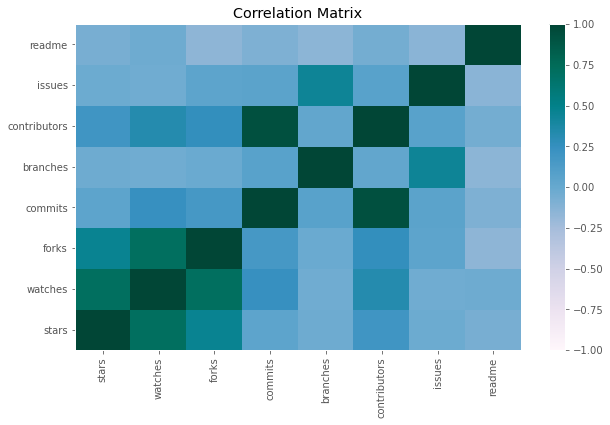

In [15]:
fig, ax = plt.subplots()
heatmap = plt.pcolor(project_corr, cmap=plt.cm.PuBuGn, vmin = -1, vmax = 1)
xy = project_corr.columns.tolist()
plt.xticks(np.arange(0.5, len(xy), 1), xy, rotation = 'vertical')
plt.yticks(np.arange(0.5, len(xy), 1), xy)
plt.title("Correlation Matrix")
plt.colorbar(heatmap)
plt.savefig('Correlation-Matrix')

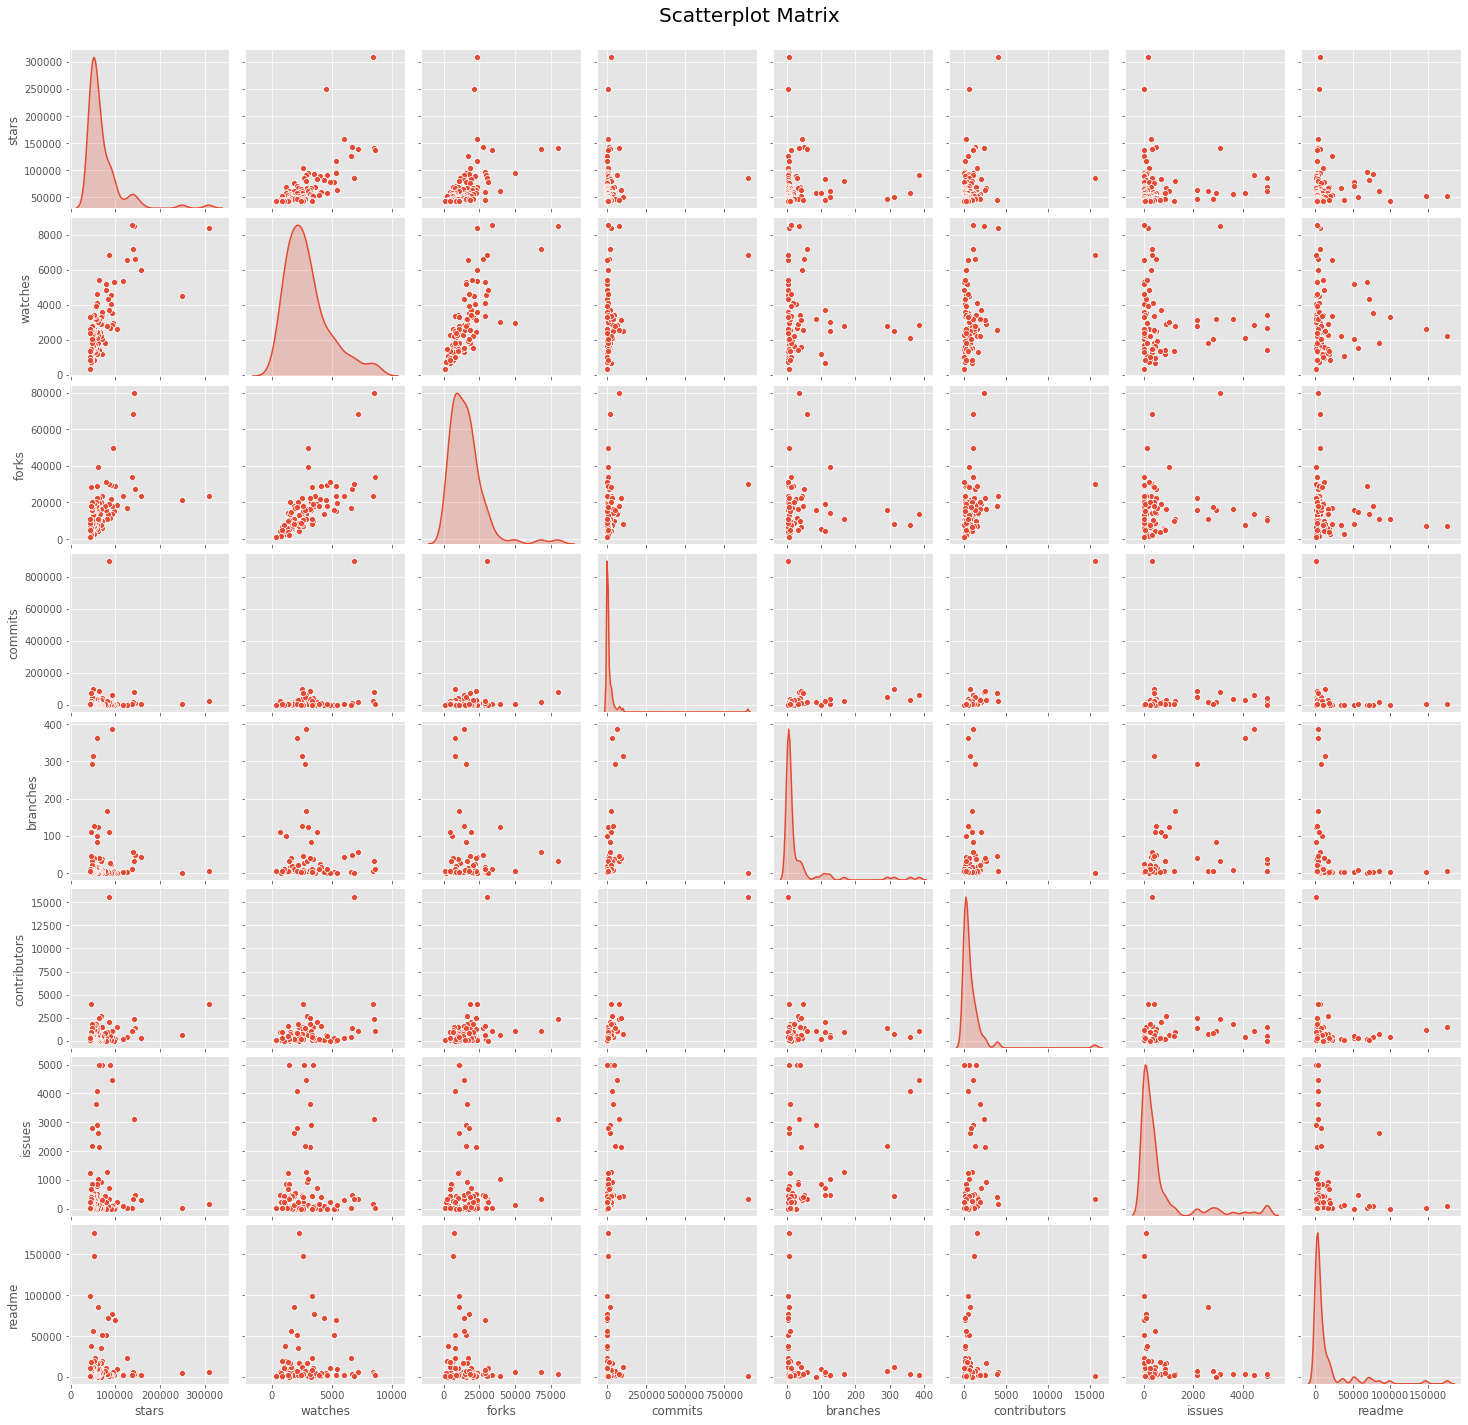

In [30]:
import seaborn as sns
rel = sns.pairplot(project_info, diag_kind="kde")

# #move title up
rel.fig.subplots_adjust(top=.95)

#add overall title
rel.fig.suptitle('Scatterplot Matrix', fontsize = 20)

plt.savefig('seaborn.png')

From these charts, we can see that there is a positive correlation between commits and contributions with the correlation being 0.933. Additionally, there is a positive correlation between the number of forks and the number of watches with the correlation being 0.71. This number is approximately similar to correlation between the number of watches and the number of stars. All other variables don't have much of a correlation with one another.

### Linear Regression

+ Now we will use a linear regression to try to predict the number of Stars based on Forks, Contributors, Issues, and README Length.
+ We will also use a linear regression to try to predict the number of Stars based on Forks, Contributors, Watches, Commits, and README Length.

In [32]:
uni_mod = sm.ols(formula="stars ~ forks + contributors + issues + readme", data = project_info)
uni_result = uni_mod.fit()
uni_result.save("longley_results.png")
print(uni_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     6.244
Date:                Fri, 15 Jul 2022   Prob (F-statistic):           0.000187
Time:                        14:41:51   Log-Likelihood:                -1071.6
No. Observations:                  90   AIC:                             2153.
Df Residuals:                      85   BIC:                             2166.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.738e+04   7345.923      6.449   

In [14]:
uni_mod = sm.ols(formula="stars ~ forks + contributors + watches + commits + readme", data = project_info)
uni_result = uni_mod.fit()
print(uni_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     24.94
Date:                Fri, 15 Jul 2022   Prob (F-statistic):           2.54e-15
Time:                        14:00:23   Log-Likelihood:                -1042.3
No. Observations:                  90   AIC:                             2097.
Df Residuals:                      84   BIC:                             2112.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.285e+04   5718.815      3.996   

From our regressions, the first model is not a good model because it has a low R-squared of 0.227, the p-values for the variables show that they are insignificant, and the prob f-statistic is small. With a low R-squared, it indicates that the independent variable is not explaining much in the variation of the dependent variable. The variable forks is significant at the 5% level, but all other variables are insignificant. Thus overall, the first model is not a good model.  The second model is better because the R-squared is higher than the first at 0.598 so around 60% of the variation is explained. Additionally, the prob f-statistic is smaller than the first model. Furthermore, commits, watches, and contributors is significant at the 5% level. Overall, the second model is better as a result from these differences.